# BDA Project
- Romain Claret
- Jämes Ménétrey
- Damien Rochat

### Load PySpark

In [1]:
import os
import findspark
findspark.init()

import pyspark

#memory = '4g'
#pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["SPARK_HOME"] = "/opt/spark"
#os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

#--driver-maxResultSize 10g --executor-memory 4g

from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("bda-spark-fare-histo")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '10g')
        .set('spark.driver.memory', '10g')
        .set('spark.driver.maxResultSize', '10g')
        .set('spark.network.timeout', '1000000000')
        .set('spark.executor.heartbeatInterval', '1000000000')
        )
sc = SparkContext(conf=conf)

### Check config

In [2]:
sc._conf.getAll()

[('spark.app.id', 'local-1559855930803'),
 ('spark.executor.memory', '10g'),
 ('spark.driver.port', '34753'),
 ('spark.driver.memory', '10g'),
 ('spark.driver.host', 'rclaret.tic.heia-fr.ch'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.maxResultSize', '10g'),
 ('spark.network.timeout', '1000000000'),
 ('spark.executor.heartbeatInterval', '1000000000'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'bda-spark-fare-histo'),
 ('spark.ui.showConsoleProgress', 'true')]

### Check if Spark is working with a little PI calculation using monte carlo

In [3]:
import random
num_samples = 100000
def inside(p):     
  x, y = random.random(), random.random()
  return x*x + y*y < 1
count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)

3.14092


### Load the Dataset

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
#df_data.count()

In [6]:
#df_data = df_maker_data("datasets/trip_data/trip_data_1.csv")
#df_fare = df_maker_fare("datasets/trip_fare/trip_fare_1.csv")
#df_merged = df_combiner(df_fare, df_data)
#df_merged.printSchema()

In [7]:
ny_lat_min = 40.50214590272583
ny_lat_max = 40.9#40.75977082462501
ny_lon_min = -74.24354116993825
ny_lon_max = -73.77490985242169

def df_load_curated(path_curated):
    return (sqlContext.read.format("csv")
                .option("delimiter", ",")
                .option("header", "true")
                .load(path_curated)
            .drop("_c0")
           )
def df_filter_curated(df):
    return (df.withColumn('fare_total', df['fare_total'].cast('float'))
            .withColumn('pickup_longitude', df['pickup_latitude'].cast('float'))
            .withColumn('pickup_latitude', df['pickup_latitude'].cast('float'))
            .filter(df.pickup_latitude<=ny_lat_max)
            .filter(df.pickup_latitude>=ny_lat_min)
            .filter(df.pickup_longitude<=ny_lon_max)
            .filter(df.pickup_longitude>=ny_lon_min)
            .filter(df.fare_total>0)
           )
#df = df_load_curated("datasets/trip_curated/undistributed/trip_curated_1.csv")
#df.printSchema()
#df = df_filter_curated(df)
#df.printSchema()

In [8]:
path_curated = "datasets/trip_curated/undistributed/"
for idx,e in enumerate(os.listdir(path_curated)):
    print(e)
    if idx == 0:
        dff = df_filter_curated(df_load_curated(path_curated+e))
    else:
        df = df_filter_curated(df_load_curated(path_curated+e))
        dff=dff.union(df)
df.printSchema()
dff.show(2)

trip_curated_8.csv
trip_curated_11.csv
trip_curated_10.csv
trip_curated_9.csv
trip_curated_4.csv
trip_curated_7.csv
trip_curated_12.csv
trip_curated_1.csv
trip_curated_5.csv
trip_curated_2.csv
trip_curated_6.csv
trip_curated_3.csv
root
 |-- fare_total: float (nullable = true)
 |-- pickup_longitude: float (nullable = true)
 |-- pickup_latitude: float (nullable = true)

+----------+----------------+---------------+
|fare_total|pickup_longitude|pickup_latitude|
+----------+----------------+---------------+
|       6.5|       40.777966|      40.777966|
|       6.0|       40.763157|      40.763157|
+----------+----------------+---------------+
only showing top 2 rows



In [24]:
import matplotlib.pyplot as plt
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram

#df_fare_filtered = df_fare.filter(df_fare.fare_total<=20).filter(df_fare.fare_total>0)
df_copy = dff.drop(dff.pickup_longitude).drop(dff.pickup_latitude)

df_copy = df_copy.filter(df_copy.fare_total<=20)

In [16]:
#df_copy.max
#from pyspark.sql.functions import max
#df_copy.select(max(df_copy.fare_total).alias(df_copy.fare_total)).show()

import pyspark.sql.functions as F
df_copy.agg(F.max(df_copy.fare_total)).first()[0]

158995.8125

Text(0.5, 1.0, 'Fare_Total Histogram Capped at 20$')

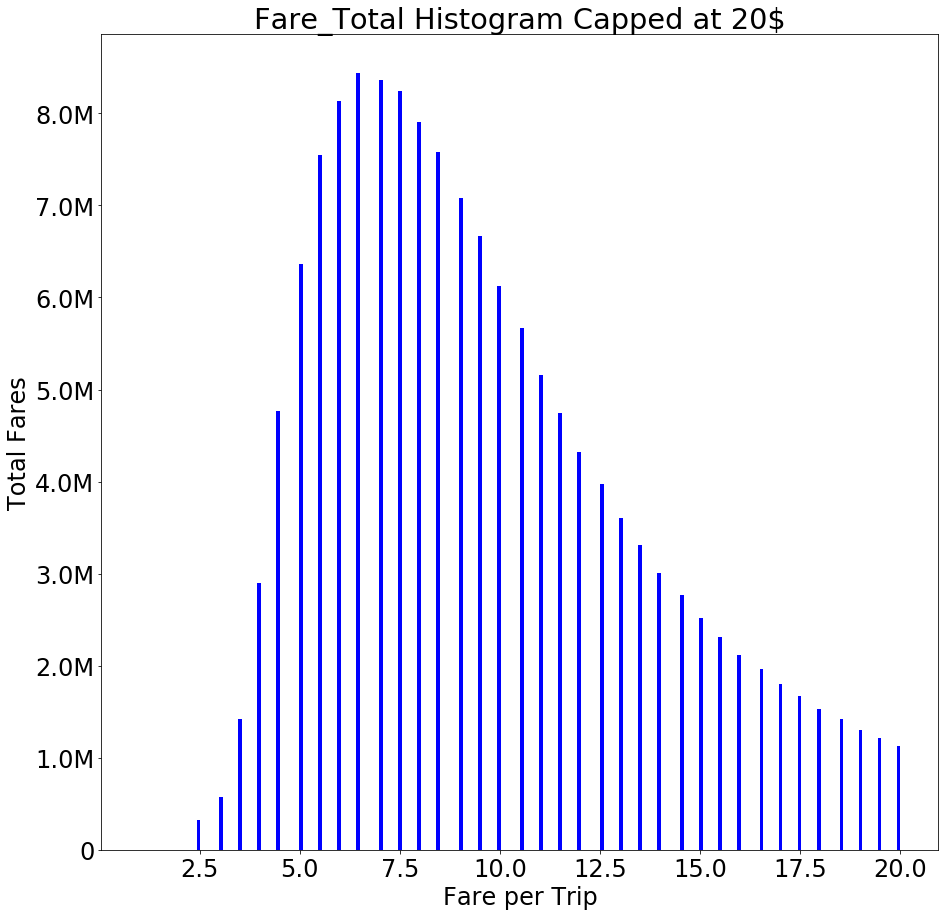

In [25]:
import time
#https://github.com/Bergvca/pyspark_dist_explore
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)

start_time = time.time()

hist(ax, df_copy, bins = 200, color=['blue'])

time.strftime("Done with: %H:%M:%S", time.gmtime(time.time() - start_time))

ax.set_xlabel("Fare per Trip")
ax.set_ylabel("Total Fares")
ax.set_title('Fare_Total Histogram Capped at 20$')

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

distplot(ax, df_fare_filtered, bins = 60, color=['blue'])
ax.set_xlabel("Fare per Trip")
ax.set_ylabel("Fares Distribution")
ax.set_title('Fare_Total Distribution')